# Question 2

## (a) Design an auto encoder to take in MNIST images with latent space dimension of 2,16,256. 

- Train auto encoder with L1-norm reconstruction loss 

- Do a 2D plot of the latent space for different digits for latent space of 2D. 

- K-means clustering for latent space of dimensions 16,256. 

- Use one color for each digit. 

- Report all results. 
- What do you notice about the reconstructed images? 

In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.manifold import TSNE
from torchsummary import summary

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = (abs(x - x_hat)).sum()  #L1 norm
            loss.backward()
            opt.step()
    return autoencoder

In [ ]:
def plot_latent_2(autoencoder, data, num_batches=100):
    z_val = []
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x)
        z = z.detach().numpy()
        z_val.append(zip(z,y))
        if i > num_batches:
            # return z_val
            break

    z_val_2 = z_val # find_latent_2(autoencoder, data)
    X_mat_2, y_act_2 = [], []
    for i in z_val_2:
      for a, b in i:
        X_mat_2.append(a)
        y_act_2.append(b.item())

    plt.scatter(np.array(X_mat_2)[:, 0], 
                np.array(X_mat_2)[:, 1], 
                s=.1, c=y_act_2)

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    z_val = []
    for i, (x, y) in enumerate(data):
        # z = torch.flatten(x, start_dim=1)
        # z = autoencoder.encoder.linear1(z)
        # z = autoencoder.encoder.linear2(z)
        z = autoencoder.encoder(x)
        z = z.detach().numpy()
        z_val.append(zip(z,y))
        if i > num_batches:
            #return z_val
            break

    # z_val = plot_latent(autoencoder, data, num_batches=100)
    X_mat, y_act = [], []
    for i in z_val:
      for a, b in i:
        X_mat.append(a)
        y_act.append(b.item())
    
    # T-SNE transformation
    X_mat_TSNE = TSNE(n_components=2).fit_transform(X_mat)

    # plot actual results
    plt.figure()
    plt.scatter(X_mat_TSNE[:, 0], 
                X_mat_TSNE[:, 1], 
                s=.1, c=y_act)
    plt.title('actual')
    plt.show()

    return X_mat_TSNE

def plot_latent_kmeans(X_mat_TSNE):
    # k-means clustering
    kmeans = KMeans(n_clusters=10)
    kmeans.fit(X_mat_TSNE)
    y_kmeans = kmeans.predict(X_mat_TSNE)
    # plot k-means results
    plt.figure()
    plt.scatter(X_mat_TSNE[:, 0], 
                X_mat_TSNE[:, 1], 
                s=.1, c=y_kmeans)
    plt.title('K-means')
    plt.show()

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

### dim = 2

In [ ]:
autoencoder_2 = Autoencoder(2)
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_2 = train(autoencoder_2, data)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
autoencoder_2

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [ ]:
# https://www.codenong.com/cs109184484/
def to_img(x):
    x = (x + 1.) * 0.5
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [ ]:
autoencoder_2

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


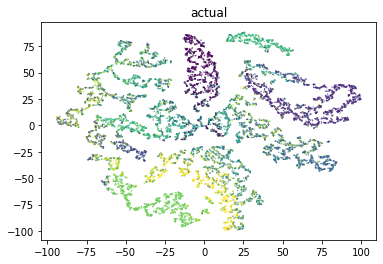

In [ ]:
X_mat_TSNE_2 = plot_latent(autoencoder_2, data, num_batches=100)

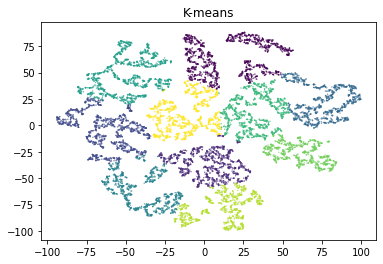

In [ ]:
plot_latent_kmeans(X_mat_TSNE_2)

### dim = 16

In [ ]:
autoencoder_16 = Autoencoder(16)
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_16 = train(autoencoder_16, data)

In [ ]:
autoencoder_16

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=16, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [ ]:
# plot_reconstructed(autoencoder_16)

In [ ]:
autoencoder_16

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=16, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


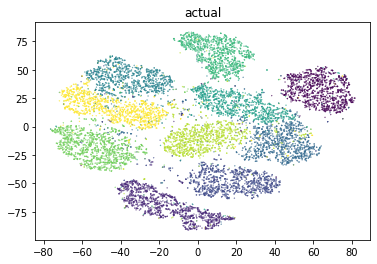

In [ ]:
X_mat_TSNE_16 = plot_latent(autoencoder_16, data, num_batches=100)

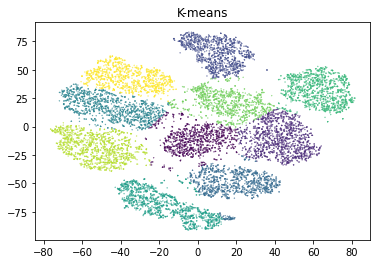

In [ ]:
plot_latent_kmeans(X_mat_TSNE_16)

### dim = 256

In [ ]:
autoencoder_256 = Autoencoder(256)
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
        batch_size=128,
        shuffle=True)
autoencoder_256 = train(autoencoder_256, data)

In [ ]:
autoencoder_256

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [ ]:
# plot_reconstructed(autoencoder_256)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


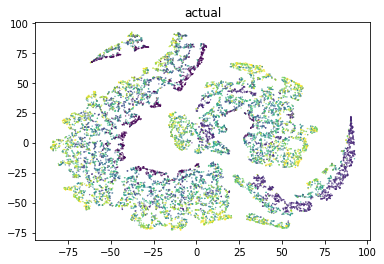

In [ ]:
X_mat_TSNE_256 = plot_latent(autoencoder_256, data, num_batches=100)

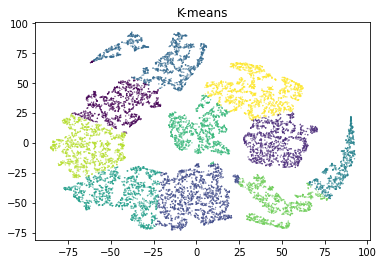

In [ ]:
plot_latent_kmeans(X_mat_TSNE_256)